# Actividad 5
Ricardo Adolfo Fernández Alvarado - A01704813

## Introducción
En esta actividad buscamos comparar el desempeño de los 3 métodos de comparación de textos en textos largos y párrafos individuales.

A continuación se encuentra el código para realizar esta comparación.

### Imports

In [1]:
from ordered_set import OrderedSet
import numpy as np
from numpy.typing import NDArray
from math import log
import pandas as pd
import os
import matplotlib.pyplot as plt

### Utilidad para limpiar texto de puntuación

In [2]:
def clean_text(text: str) -> list[str]:
        return ''.join(c.lower() if c.isalnum() or c == " " else '' for c in text).split()

### Cálculo del coseno a partir de dos vectores

In [3]:
def calculate_similarity(vec1: NDArray[np.int64], vec2: NDArray[np.int64]) -> float:
    dot = np.dot(vec1, vec2)
    vec1_mag = np.linalg.norm(vec1)
    vec2_mag = np.linalg.norm(vec2)

    if vec1_mag == 0 or vec2_mag == 0:
        return 0

    return dot / (vec1_mag * vec2_mag)


### Utilidad para el cálculo de frequencia de palabra en una oración

In [4]:
def word_freq(words: list[str]) -> dict[str, int]:
    freqs = {}
    for word in words:
        if word in freqs.keys():
            freqs[word] += 1
        else:
            freqs[word] = 1

    return freqs

### Utilidad para la creación de el BOW

In [5]:
def create_bow(s_words: list[str], t_words: list[str]) -> list[str]:
    return list(OrderedSet(s_words + t_words))

### Función para vectorizar un par de oraciones a través de BOW

In [6]:
def vectorize_bow(s_freq: dict[str, int], t_freq: dict[str, int], bow: list[str]) -> tuple[NDArray[np.int64], NDArray[np.int64]]:

    vec_s = []
    vec_t = []

    for word in bow:
        if word in s_freq.keys():
            vec_s.append(s_freq[word])
        else:
            vec_s.append(0)

        if word in t_freq.keys():
            vec_t.append(t_freq[word])
        else:
            vec_t.append(0)

    return np.array(vec_s), np.array(vec_t)


### Función para vectorizar un par de oraciones utilizando TF-IDF

In [7]:
def vectorize_tfidf(s_freq: dict[str, int], t_freq: dict[str, int], bow: list[str]) -> tuple[NDArray[np.int64], NDArray[np.int64]]:
    s_words = len(s_freq)
    t_words = len(t_freq)
    tf_s = []
    tf_t = []
    idf = []

    for word in bow:
        contained_in = 0
        if word in s_freq.keys():
            tf_s.append(s_freq[word] / s_words)
            contained_in += 1
        else:
            tf_s.append(0)

        if word in t_freq.keys():
            tf_t.append(t_freq[word] / t_words)
            contained_in += 1
        else:
            tf_t.append(0)

        idf.append(log(2 / (contained_in + 1)) + 1)

    vec_s = [i * j for i, j in zip(tf_s, idf)]
    vec_t = [i * j for i, j in zip(tf_t, idf)]

    return (np.array(vec_s), np.array(vec_t))

### Función para construir una matriz de Markov a partir de 2 oraciones

In [8]:
def generate_markov_chain(s_words: list[str], t_words: list[str], bow: list[str]) -> tuple[NDArray, NDArray]:
    s_matrix = [[0. for _ in range(len(bow))] for _ in range(len(bow))]
    t_matrix = [[0. for _ in range(len(bow))] for _ in range(len(bow))]

    for i in range(1, len(s_words)):
        currIdx = bow.index(s_words[i])
        prevIdx = bow.index(s_words[i-1])
        s_matrix[prevIdx][currIdx] += 1

    for i in range(1, len(t_words)):
        currIdx = bow.index(t_words[i])
        prevIdx = bow.index(t_words[i-1])
        t_matrix[prevIdx][currIdx] += 1

    for matrix in [s_matrix, t_matrix]:
        for row in matrix:
            total = sum(row)
            if total == 0:
                continue
            for i in range(len(row)):
                row[i] = row[i] / total

    return (np.array(s_matrix), np.array(t_matrix))

### Utilidad para calcular qué tan cercano está un resultado

In [9]:
def calculate_correctness(original_similiraty: str, calculated_similarity: float):
    if original_similiraty == "high":
        return calculated_similarity >= 0.85
    elif original_similiraty == "moderate":
        return 0.85 >= calculated_similarity >= 0.45
    else:
        return calculated_similarity <= 0.45

### Procesamiento de los textos

In [17]:
original_text = open("texts/original.txt").read()
clean_original_text = clean_text(original_text)
original_text_freq = word_freq(clean_original_text)

texts_df = pd.DataFrame(
    columns=[
        "Texto Original",
        "Texto Similar",
        "Grado de similitud precargado",
        "Coseno de BOW",
        "BOW en rango",
        "Coseno de TFIDF",
        "TFIDF en rango",
        "Coseno de Markov",
        "Markov en rango",
    ]
)

text_files = os.listdir("texts")
text_files.sort()

for idx, file_name in enumerate(text_files):
    if file_name == "original.txt":
        continue

    file = open("texts/" + file_name).read()
    clean_file = clean_text(file)
    clean_file_freq = word_freq(clean_file)
    bow = create_bow(clean_original_text, clean_file)

    v1_bow, v2_bow = vectorize_bow(original_text_freq, clean_file_freq, bow)
    v1_tfidf, v2_tfidf = vectorize_tfidf(original_text_freq, clean_file_freq, bow)
    m1_markov, m2_markov = generate_markov_chain(
        clean_original_text, clean_file, bow
    )

    cos_bow = calculate_similarity(v1_bow, v2_bow)
    cos_tfidf = calculate_similarity(v1_tfidf, v2_tfidf)
    cos_markov = calculate_similarity(m1_markov.flatten(), m2_markov.flatten())

    similiraty_grade = file_name.split("_")[0]

    texts_df.loc[idx] = [
        "original.txt",
        file_name,
        similiraty_grade,
        cos_bow,
        calculate_correctness(similiraty_grade, cos_bow),
        cos_tfidf,
        calculate_correctness(similiraty_grade, cos_tfidf),
        cos_markov,
        calculate_correctness(similiraty_grade, cos_markov),
    ]

texts_df.to_csv("texts.csv")
texts_df.head(10)

,Texto Original,Texto Similar,Grado de similitud precargado,Coseno de BOW,BOW en rango,Coseno de TFIDF,TFIDF en rango,Coseno de Markov,Markov en rango
0,original.txt,high_00.txt,high,0.897899,True,0.773711,False,0.208259,False
1,original.txt,high_01.txt,high,0.813446,False,0.664455,False,0.111011,False
2,original.txt,high_02.txt,high,0.758638,False,0.587708,False,0.138941,False
3,original.txt,high_03.txt,high,0.596301,False,0.419487,False,0.043081,False
4,original.txt,low_01.txt,low,0.581127,False,0.379363,True,0.029324,True
5,original.txt,low_02.txt,low,0.367637,True,0.237730,True,0.031765,True
6,original.txt,low_03.txt,low,0.383208,True,0.213890,True,0.044743,True
7,original.txt,moderate_01.txt,moderate,0.716954,True,0.538711,True,0.072251,False
8,original.txt,moderate_02.txt,moderate,0.637445,True,0.452600,True,0.050071,False
9,original.txt,moderate_03.txt,moderate,0.454765,True,0.283175,False,0.020260,False


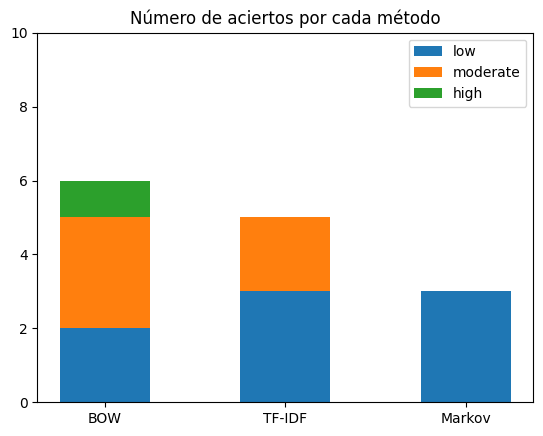

In [11]:
methods = ["BOW", "TF-IDF", "Markov"]

low_similarity = texts_df["Grado de similitud precargado"] == "low"
moderate_similarity = texts_df["Grado de similitud precargado"] == "moderate"
high_similarity = texts_df["Grado de similitud precargado"] == "high"

bow_in_range = texts_df["BOW en rango"] == True
tfidf_in_range = texts_df["TFIDF en rango"] == True
markov_in_range = texts_df["Markov en rango"] == True

low_bow = (low_similarity & bow_in_range).sum()
low_tfidf = (low_similarity & tfidf_in_range).sum()
low_markov = (low_similarity & markov_in_range).sum()

moderate_bow = (moderate_similarity & bow_in_range).sum()
moderate_tfidf = (moderate_similarity & tfidf_in_range).sum()
moderate_markov = (moderate_similarity & markov_in_range).sum()

high_bow = (high_similarity & bow_in_range).sum()
high_tfidf = (high_similarity & tfidf_in_range).sum()
high_markov = (high_similarity & markov_in_range).sum()

success_counts = {
    "low": [low_bow, low_tfidf, low_markov],
    "moderate": [moderate_bow, moderate_tfidf, moderate_markov],
    "high": [high_bow, high_tfidf, high_markov]
}

fig, ax = plt.subplots()
bottom = np.zeros(3)

for similiraty_grade, success_count in success_counts.items():
    p = ax.bar(methods, success_count, 0.5, label=similiraty_grade, bottom=bottom)
    bottom += success_count

ax.set_title("Número de aciertos por cada método")
ax.set_ylim(0, 10)
ax.legend(loc="upper right")

plt.show()

## Resultados

Como se puede observar en la gráfica, el método que más aciertos tuvo fue BOW, obteniendo incluso un acierto en un texto de similitud alta, lo que no logró ninguno de los otros métodos. Sin embargo, es importante tener en cuenta que BOW busca la aparición de palabras en ambos documentos, lo que puede generar altos índices de similitud en textos que hablen de temas similares pero con ideas distintas.

Markov tuvo un resultado bastante bajo debido a que éste busca secuencias específicas, y en este caso en particular, aunque había palabras similares, no se repetían las estructuras.

TF-IDF tuvo un mejor rendimiento en los textos de baja similitud seguramente debido a que TD-IDF si considera si una palabra aparece en solo uno o dos de los textos, lo que hace que la similtud baje drásticamente en textos que no comparten palabras entre sí.

### Procesamiento de los párrafos

In [18]:
original_paragraphs = open("paragraphs/base_paragraph.txt").read()
clean_original_paragraph = clean_text(original_paragraphs)
original_paragraph_freq = word_freq(clean_original_paragraph)

paragraphs_df = pd.DataFrame(
    columns=[
        "Texto Original",
        "Texto Similar",
        "Grado de similitud precargado",
        "Coseno de BOW",
        "Error de BOW",
        "Coseno de TFIDF",
        "Error de TFIDF",
        "Coseno de Markov",
        "Error de Markov"
    ]
)

paragraph_files = os.listdir("paragraphs/")
paragraph_files.sort()

for idx, file_name in enumerate(paragraph_files):
    if file_name == "base_paragraph.txt":
        continue

    file = open("paragraphs/" + file_name).read()
    clean_file = clean_text(file)
    clean_file_freq = word_freq(clean_file)
    bow = create_bow(clean_original_paragraph, clean_file)

    v1_bow, v2_bow = vectorize_bow(original_paragraph_freq, clean_file_freq, bow)
    v1_tfidf, v2_tfidf = vectorize_tfidf(original_paragraph_freq, clean_file_freq, bow)
    m1_markov, m2_markov = generate_markov_chain(
        clean_original_paragraph, clean_file, bow
    )

    cos_bow = calculate_similarity(v1_bow, v2_bow)
    cos_tfidf = calculate_similarity(v1_tfidf, v2_tfidf)
    cos_markov = calculate_similarity(m1_markov.flatten(), m2_markov.flatten())

    similiraty_grade = float(file_name.split("_")[2].strip(".txt"))

    paragraphs_df.loc[idx] = [
        "base_paragraph.txt",
        file_name,
        similiraty_grade,
        cos_bow,
        abs(similiraty_grade - cos_bow),
        cos_tfidf,
        abs(similiraty_grade - cos_tfidf),
        cos_markov,
        abs(similiraty_grade - cos_markov),
    ]

paragraphs_df.to_csv("paragraphs.csv")
paragraphs_df.head(10)

,Texto Original,Texto Similar,Grado de similitud precargado,Coseno de BOW,Error de BOW,Coseno de TFIDF,Error de TFIDF,Coseno de Markov,Error de Markov
0,base_paragraph.txt,1_sim_0.7000.txt,0.7000,0.854155,0.154155,0.717809,0.017809,0.683871,0.016129
1,base_paragraph.txt,2_sim_0.6644.txt,0.6644,0.840691,0.176291,0.693221,0.028821,0.621331,0.043069
2,base_paragraph.txt,3_sim_0.6652.txt,0.6652,0.826083,0.160883,0.682285,0.017085,0.622448,0.042752
3,base_paragraph.txt,4_sim_0.5328.txt,0.5328,0.861439,0.328639,0.731561,0.198761,0.682041,0.149241
4,base_paragraph.txt,5_sim_0.9982.txt,0.9982,0.997715,0.000485,0.994481,0.003719,0.963864,0.034336
5,base_paragraph.txt,6_sim_0.9992.txt,0.9992,0.997716,0.001484,0.994944,0.004256,0.965218,0.033982
6,base_paragraph.txt,7_sim_0.9981.txt,0.9981,0.997717,0.000383,0.994717,0.003383,0.965248,0.032852
7,base_paragraph.txt,8_sim_0.9981.txt,0.9981,0.997715,0.000385,0.994481,0.003619,0.963864,0.034236


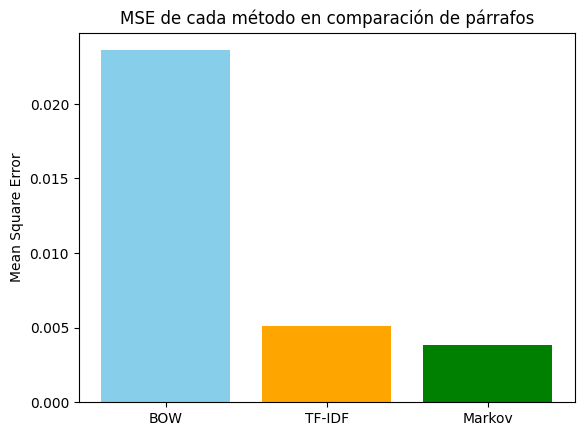

In [13]:
mse_bow = (paragraphs_df["Error de BOW"] ** 2).mean()
mse_tfidf = (paragraphs_df["Error de TFIDF"] ** 2).mean()
mse_markov = (paragraphs_df["Error de Markov"] ** 2).mean()

mse_values = [mse_bow, mse_tfidf, mse_markov]
methods = ["BOW", "TF-IDF", "Markov"]

plt.bar(methods, mse_values, color=["skyblue", "orange", "green"])
plt.ylabel("Mean Square Error")
plt.title("MSE de cada método en comparación de párrafos")
plt.show()

## Resultados

En este caso podemos ver que BOW fue el que tuvo un peor desempeño, ya que tiene un MSE más grande, lo que quiere decir que fue el algoritmo que cuando tuvo errores, eran los más grandes. En cambio, Markov tuvo un mucho mejor resultado ya que a diferencia de los textos, los párrafos sí tenían secuencias de palabras que se repetían.

En TF-IDF se observa como mejora en comparación con BOW ya que TF-IDF si toma en cuenta si una palabra aparece o no en los dos textos.